In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(training_set[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

In [3]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

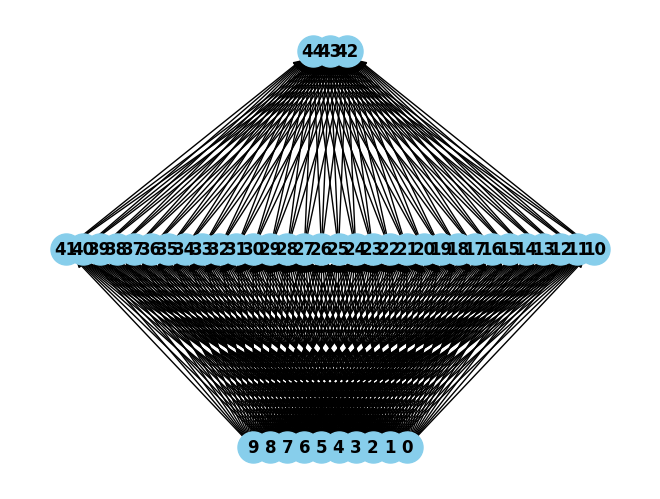

In [4]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [5]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [6]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [7]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [8]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)

In [9]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [10]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [11]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [12]:
orig_df

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,"{'adamax': False, 'exp_decay_rate_2': 0.999, '...",8,150,500,5,0.000001,1.000000e-09,0.11,0.85,200,False,0.098424,0.013096,0.000005,5.119440e-07,0.009886


In [13]:
gen = np.random.default_rng(seed=None)
def get_new_tr_vl(pattern_set, len_ds, gen):
    return gen.choice(pattern_set, len_ds)

In [14]:
n_models = 3
tr_len = 533
mod = []
for i in range(n_models):
    
    tr = get_new_tr_vl(tr_normalized[:533], 533, gen)
    NN = NeuralNetwork(sigmoid_l1, -0.75, 0.75, True, i + RANDOM_STATE)
    stats = NN.train(training_set =tr, 
                    validation_set = tr_normalized[533:], 
                    
                    batch_size= 8, 
                    max_epochs= 500, 
                    min_epochs= 150,
                    retrainig_es_error = orig_df.iloc[0]['mean_best_validation_training_error'],
                    patience = 5, 
                    error_increase_tolerance = 0.000001, 
                    
                    lambda_tikhonov = 1.000000e-09, # off
                    
                    adamax = False,
                    
                    learning_rate = 0.09/8,
                    lr_decay_tau = 185, # off
                    eta_tau= 0.09*0.01,
                    alpha_momentum = 0.92, # off
                    nesterov = False,
                    
                    metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ], 
                    collect_data=True, 
                    collect_data_batch=False, 
                    verbose=True)
    mod.append([NN, stats, tr])
    with open('../data/net/models_6_ens/model_' + str(i) + '.json', 'w+') as file:
            file.write(NN.toJSON())


starting values:  {'training_set_len': 533, 'minibatch_size': 8, 'max_epochs': 500, 'retrainig_es_error': 0.011863399731971879, 'error_increase_tolerance': 1e-06, 'patience': 5, 'min_epochs': 150, 'learning_rate': 0.01125, 'lr_decay_tau': 185, 'eta_tau': 0.0009, 'lambda_tikhonov': 1e-09, 'alpha_momentum': 0.92, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.01, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999991), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'train

[1/500] tr time: 0:00:00.993861 | mean_squared_error: tr=0.571977638012458 val=0.5296719274723135 | | mean_euclidean_error: tr=0.7093074499402083 val=0.6880312943307381 | 
[2/500] tr time: 0:00:01.010093 | mean_squared_error: tr=0.1362960508784047 val=0.14361291003899213 | | mean_euclidean_error: tr=0.33517312838492125 val=0.33921348559083586 | 
[3/500] tr time: 0:00:00.917454 | mean_squared_error: tr=0.10450568385043951 val=0.10454650627248296 | | mean_euclidean_error: tr=0.29260041084188615 val=0.2940215924711978 | 
[4/500] tr time: 0:00:00.932672 | mean_squared_error: tr=0.08383166667825749 val=0.08330262572260073 | | mean_euclidean_error: tr=0.2643187071831232 val=0.2592671083125586 | 
[5/500] tr time: 0:00:01.183750 | mean_squared_error: tr=0.07893982194612988 val=0.06793611367895588 | | mean_euclidean_error: tr=0.2531825196971487 val=0.23104669649337609 | 
[6/500] tr time: 0:00:00.928982 | mean_squared_error: tr=0.058422990905590264 val=0.054503344333967314 | | mean_euclidean_err

In [ ]:
def construct_obj(list_mod):
    interesting_model = []
    for i in range(len(list_mod)):
        
        dummy = {}
        dummy['nn_file_name'] = '../data/net/models_6_ens/model_' + str(i) + '.json'
        dummy['index'] = i
        dummy['model'] = list_mod[i][0]
        dummy['stats'] = list_mod[i][1]
        dummy['top_name'] = '32_sigmoid'
        
        dummy['std_prediction_tr'] = dummy['model'].predict_array(list_mod[i][2][:,:TR_INPUT])
        dummy['std_prediction_val'] = dummy['model'].predict_array(tr_normalized[tr_len:,:TR_INPUT])
        
        dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
        dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])

        dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], list_mod[i][2][:,TR_INPUT:])
        dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[tr_len:,TR_INPUT:])
             
        dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], scaler_out.inverse_transform(list_mod[i][2][:,TR_INPUT:]))
        dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[tr_len:,TR_INPUT:])
        interesting_model.append(dummy)
        
    return interesting_model

In [ ]:
models_list = construct_obj(mod)

In [ ]:
with open('../data/net/models_6_ens/models.json', 'w+') as file:
    save_obj(models_list, file)

In [ ]:
interesting_model = load_obj('../data/net/models_6_ens/models.json')

In [ ]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_mean_euclidean_error','validation_mean_euclidean_error']
    cols_name = ['tmse','vmse','tmee','vmee']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [ ]:
df_im

,nn_file_name,index,model,top_name,std_prediction_tr,std_prediction_val,prediction_tr,prediction_val,std_tr_error,std_val_error,tr_error,val_error,tmse,vmse,tmee,vmee
0,../data/net/models_6_ens/model_0.json,0,id: 41 w: [-2.93578872 -0.77964569 1.80703312...,32_sigmoid,[[ 0.59970281 0.72531929 0.78405447]\n [-2.3...,[[ 6.40976952e-01 -1.36501786e-01 1.63019926e...,[[ 4.43801389 5.19196851 25.35320213]\n [-...,[[ 5.51222900e+00 -1.99266651e+01 3.40067266e...,0.094403,0.126989,2.079892,2.455508,"[0.9583412772558533, 0.26985500496169496, 0.18...","[0.8881478810222058, 0.2941372823103613, 0.207...","[0.8772635527251008, 0.4697464271673671, 0.393...","[0.8411642158168466, 0.49134211326126603, 0.41..."


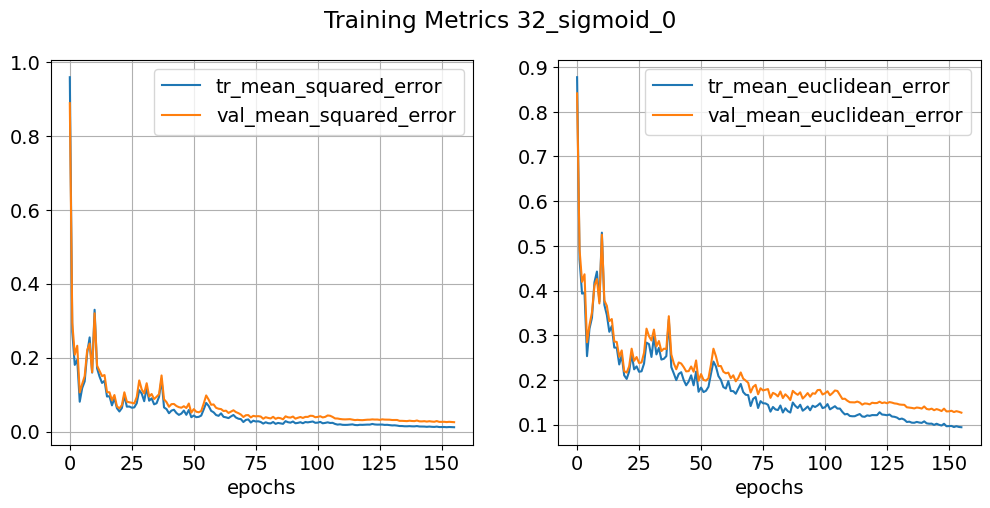

In [ ]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(12, 5))
    plt.suptitle('Training Metrics ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['tr_' + metrics[i].__name__, 'val_' + metrics[i].__name__],
                ax=ax[i])

In [ ]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()

In [ ]:
def ensemlbe(compl_obj, set):

    output = np.empty((len(set), TR_OUTPUT))
    
    for i, el in enumerate(set):
        dummy = np.zeros(TR_OUTPUT)
        for j in range(len(compl_obj)):
            dummy += compl_obj[j]['model'].predict(el)
            
        output[i] = dummy/len(compl_obj)
    return output
    

In [ ]:
str_prediction_tr = ensemlbe(interesting_model, tr_normalized[:tr_len,:TR_INPUT])
str_prediction_val = ensemlbe(interesting_model, tr_normalized[tr_len:,:TR_INPUT])
str_prediction_test = ensemlbe(interesting_model, test_normalized[:,:TR_INPUT])

prediction_tr = scaler_out.inverse_transform(str_prediction_tr)
prediction_val = scaler_out.inverse_transform(str_prediction_val)
prediction_test = scaler_out.inverse_transform(str_prediction_test)

std_error_tr = ErrorFunctions.mean_euclidean_error(str_prediction_tr, tr_normalized[:tr_len,TR_INPUT:])
std_error_val = ErrorFunctions.mean_euclidean_error(str_prediction_val, tr_normalized[tr_len:,TR_INPUT:])
std_error_test = ErrorFunctions.mean_euclidean_error(str_prediction_test, test_normalized[:,TR_INPUT:])

error_tr = ErrorFunctions.mean_euclidean_error(prediction_tr, training_set[:tr_len,TR_INPUT:])
error_val = ErrorFunctions.mean_euclidean_error(prediction_val, training_set[tr_len:,TR_INPUT:])
error_test = ErrorFunctions.mean_euclidean_error(prediction_test, test_set[:,TR_INPUT:])

In [ ]:
print('std_error_tr:', std_error_tr)
print('std_error_val:', std_error_val)
print('std_error_test:', std_error_test)
print('error_tr:', error_tr)
print('error_val:', error_val)
print('error_test:', error_test)

std_error_tr: 0.11033821144649371
std_error_val: 0.1269888386220167
std_error_test: 0.12946777204109447
error_tr: 2.350724384523165
error_val: 2.4555075070325887
error_test: 2.658593659917214


In [ ]:
learning_curve = 